In [3]:
import pandas as pd
import numpy as np
from sympy import * 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
AutoMinorLocator)
sns.set_style("whitegrid")

### Пользовательские функции

In [4]:
def take_date(string):
    '''
    Функция для вытаскивания даты из колонки 
    'actual_departure' без времени.
    '''
    
    dat = datetime.strptime(string, '%Y-%m-%dT%H:%M:%SZ')
    dat =  dat.strftime('%Y-%m-%d')
    return dat

def take_month(string):
    '''
    Функция для вытаскивания месяца из колонки 
    'actual_departure' без времени.
    '''
    
    dat = datetime.strptime(string, '%Y-%m-%dT%H:%M:%SZ')
    dat =  dat.strftime('%m')
    return dat

def take_day(string):
    '''
    Функция для вытаскивания дня из колонки 
    'actual_departure' без времени.
    '''
    
    dat = datetime.strptime(string, '%Y-%m-%dT%H:%M:%SZ')
    dat =  dat.strftime('%d')
    return dat

def take_time(string):
    '''
    Функция для вытаскивания времени из колонки 
    'actual_departure' без времени.
    '''
    
    dat = datetime.strptime(string, '%Y-%m-%dT%H:%M:%SZ')
    dat =  dat.strftime('%H:%M')
    return dat

def exp(air_cod, time):
    '''
    Функция для расчета расходов на рейс.
    Учитывает время полета, время на аэронавигационное маневрирование,
    сбор на авианавигатационное обслуживание
    
    '''
    As = 148.8
    F = 41637
    Am = 2 # Время на аэронавигационное маневрирование (2 часа)
    # Расчет для самолета Боинг
    
    if air_cod == '733':
        Fc = 2.600 # Расход топлива на крейсерской скорости, кг/ч
        MTOW = 62.820 # Максимальый взлетный вес самолета
        expense = (((time * Fc) + (Am*(1/2*Fc))) * F)+As*MTOW
        return int(expense)
    elif air_cod == 'SU9':
        Fc = 1.622 # Расход топлива на крейсерской скорости, кг/ч
        MTOW = 45.800 # Максимальый взлетный вес самолета
        expense = (((time * Fc) + (Am*(1/2*Fc))) * F)+As*MTOW
        return int(expense)
    else:
        return 'Ошибка'

def desc_fly(dat):
    ''' 
    Функция показывает среднее, макисмальное
    и минимальыне значения прибыли
    '''
    dat_s = dat['profit'].describe().reset_index()
    dat_s_mean = round(dat_s[dat_s['index'] == 'mean'].iloc[0]['profit'])
    dat_s_max = (dat_s[dat_s['index'] == 'max'].iloc[0]['profit'])
    dat_s_min = (dat_s[dat_s['index'] == 'min'].iloc[0]['profit'])
    
    print('Максимальная прибыль - {} руб,\nСредняя прибыль-{} руб,\
    \nМинимальная прибыль-{} руб'.format(dat_s_max, dat_s_mean, dat_s_min))
    
def per_seat(dat, feb=False):
    '''
    Функция показывает уровень заполнености 
    в течении месяца
    '''
    if feb == True:
        s70 = round(len(dat.query('70<=full_of_seat<80'))/28*100, 2)
        s80 = round(len(dat.query('80<=full_of_seat<90'))/28*100, 2)
        s90 = round(len(dat.query('90<=full_of_seat<100'))/28*100, 2)
        s100 = round(len(dat.query('full_of_seat==100'))/28*100, 2)
    else:
        s70 = round(len(dat.query('70<=full_of_seat<80'))/31*100, 2)
        s80 = round(len(dat.query('80<=full_of_seat<90'))/31*100, 2)
        s90 = round(len(dat.query('90<=full_of_seat<100'))/31*100, 2)
        s100 = round(len(dat.query('full_of_seat==100'))/31*100, 2)
    
    print('Заполняемость самолета в рейсе, за месяц:\n70+ - {} %,\n80+ - {} %,\
    \n90+ - {} %,\n100 - {} %'.format(s70, s80, s90, s100))
    
def profit_on_day(dat):
    '''
    Функция для визуализации прибыльности
    по дням недели
    
    '''
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.title('Рейсы с прибылью меньше среднего значения')
    d = dat[dat['profit'] < dat['profit'].mean()]
    d['dow'].value_counts(ascending=True).plot(kind='barh')
    plt.xlabel('Количество рейсов')
    plt.ylabel('День недели')

    plt.subplot(122)
    plt.title('Рейсы с прибылью больше среднего значения')
    d = dat[dat['profit'] >= dat['profit'].mean()]
    d['dow'].value_counts(ascending=True).plot(kind='barh')
    plt.xlabel('Количество рейсов')
    plt.ylabel('День недели')

def profit_on_seat(dat):
    '''
    Функция для визуализации прибыльности
    от заполняемости
    по дням недели
    
    '''
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.title('Рейсы с заполняемостью меньше среднего значения')
    d = dat[dat['full_of_seat'] < dat['full_of_seat'].mean()]
    d['dow'].value_counts(ascending=True).plot(kind='barh')
    plt.xlabel('Количество рейсов')
    plt.ylabel('День недели')

    plt.subplot(122)
    plt.title('Рейсы сзаполняемостью больше среднего значения')
    d = dat[dat['full_of_seat'] >= dat['full_of_seat'].mean()]
    d['dow'].value_counts(ascending=True).plot(kind='barh')
    plt.xlabel('Количество рейсов')
    plt.ylabel('День недели')    

In [5]:
df = pd.read_csv('query_result_anapa.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          193 non-null    int64  
 1   flight_no          193 non-null    object 
 2   departure_airport  193 non-null    object 
 3   arrival_airport    193 non-null    object 
 4   actual_departure   193 non-null    object 
 5   status             193 non-null    object 
 6   aircraft_code      193 non-null    object 
 7   ticket_economy     180 non-null    float64
 8   ticket_comfort     180 non-null    float64
 9   ticket_bisiness    180 non-null    float64
 10  total_amount       180 non-null    float64
 11  cnt_seats          193 non-null    int64  
 12  fly_time           193 non-null    float64
 13  dow                193 non-null    float64
dtypes: float64(6), int64(2), object(6)
memory usage: 21.2+ KB


При первом просмотре на данные можно сделать следующие выводы:
    - из 14 колонок 8 колонок в числовом формате, остальные строки. 
    - есть пустые значения в строках по классу билета и стоимости. 
    - количесвто проданых мест в каждом классе, день недели полета следует перевести в класс int.
    - колонку fly_time (время полета) следует округлить до 2х знаков после запятой. 

In [7]:
df.sample(5)

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,status,aircraft_code,ticket_economy,ticket_comfort,ticket_bisiness,total_amount,cnt_seats,fly_time,dow
64,136390,PG0252,AAQ,SVO,2016-12-26T10:06:00Z,Arrived,733,113.0,0.0,12.0,1823800.0,130,1.683333,1.0
74,136439,PG0252,AAQ,SVO,2017-02-25T10:08:00Z,Arrived,733,106.0,0.0,11.0,1701800.0,130,1.666667,6.0
154,136801,PG0480,AAQ,EGO,2016-12-30T09:28:00Z,Arrived,SU9,85.0,0.0,12.0,765300.0,97,0.833333,5.0
162,136838,PG0480,AAQ,EGO,2017-01-24T09:30:00Z,Arrived,SU9,76.0,0.0,10.0,670200.0,97,0.850000,2.0
175,136875,PG0480,AAQ,EGO,2017-02-16T09:29:00Z,Arrived,SU9,85.0,0.0,12.0,765300.0,97,0.833333,4.0


Проверка датасета на наличие дубликатов

In [8]:
#Проверим датасет на наличие дубликатов:
if len(df)>len(df.drop_duplicates()):
    print('Дубликаты есть')
    display(df[df.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


Подсчет количества пропусков в датасете

In [9]:
for col in df.columns:
    pct_missing = df[col].isna().mean()
    print('{} - {}%'.format(col, round((pct_missing*100), 1)))

flight_id - 0.0%
flight_no - 0.0%
departure_airport - 0.0%
arrival_airport - 0.0%
actual_departure - 0.0%
status - 0.0%
aircraft_code - 0.0%
ticket_economy - 6.7%
ticket_comfort - 6.7%
ticket_bisiness - 6.7%
total_amount - 6.7%
cnt_seats - 0.0%
fly_time - 0.0%
dow - 0.0%


Огорчает, что есть пропуски в колонке total_amount - главной, для расчета прибыльности рейса. 

Посмотрим на колонки

In [10]:
len(df['flight_id'].unique())

193

В колонке flight_id все значения уникальны

In [11]:
df['flight_no'].unique()

array(['PG0252', 'PG0194', 'PG0480'], dtype=object)

Из Анапы улетают рейсы с 3 уникальными номерами. 

In [12]:
df['departure_airport'].unique()

array(['AAQ'], dtype=object)

Аэропорт в Анапе один, колонка не информативна будет удалена. 

In [13]:
df['arrival_airport'].unique()

array(['SVO', 'NOZ', 'EGO'], dtype=object)

Из Анапы зимой, самолеты летят только по 3 направлениям. 
Это:
    
    Москва (SVO)
    
    Новокузнецк (NOZ)
    
    Белгород (EGO)

Колонка actual_departure - дата и время вылета самолета. У нас нет даты и времени прилета, так как данные о длительности полета были подсчитаны при выгрузке данных и находятся в колонке fly_time. Длительность полета в часах. 

In [14]:
df['status'].unique()

array(['Arrived'], dtype=object)

Мы рассматриваем исключительно состоявшиеся рейсы. Так как на рейсах со статусом departure - 'Самолет уже вылетел и находится в воздухе' нельзя точно подсчитать время самолета в пути, а следовательно и расход топлива. Так как колонка имеет только одно значение, удалим ее.

In [15]:
df['aircraft_code'].unique()

array(['733', 'SU9'], dtype=object)

In [16]:
df['aircraft_code'].value_counts()

733    103
SU9     90
Name: aircraft_code, dtype: int64

Из Анапы летают только 2 самолета это:
    
    SU9 - Sukhoi Superjet 100
    
    733 - Boeing 737-300

In [17]:
df['ticket_comfort'].unique()

array([ 0., nan])

На данных самолетах нет мест класса комфорт, удалим этот столбец. Остальные 2 столбца ticket_ показывают заполняемость мест в каждом классе, для каждого рейса. 

In [18]:
df['total_amount'].describe()

count    1.800000e+02
mean     1.179647e+06
std      4.811836e+05
min      5.310000e+05
25%      7.385250e+05
50%      1.068850e+06
75%      1.631950e+06
max      1.886000e+06
Name: total_amount, dtype: float64

<AxesSubplot:>

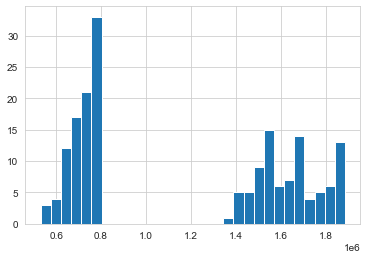

In [19]:
df['total_amount'].hist(bins=30)


Максимальная общая стоимость билетов 1_886_000 рублей, минимальная 531_000. Медианная цена билетов не первышает 1_068_850 рублей.

In [20]:
df['cnt_seats'].unique()

array([130,  97], dtype=int64)

Общее количесвто мест в самолете где:

    SU9 - 97
    
    733 - 130

In [21]:
df['fly_time'].describe()

count    193.000000
mean       1.508981
std        1.047745
min        0.816667
25%        0.833333
50%        1.650000
75%        1.666667
max        5.200000
Name: fly_time, dtype: float64

<AxesSubplot:>

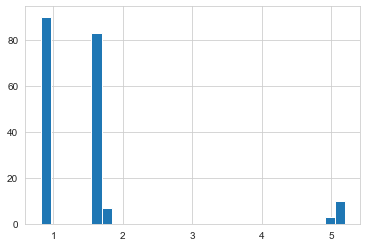

In [22]:
df['fly_time'].hist(bins=30)

Среднее время полета самолетов из Анапы зимой немного больше 1,5 часов. Минимальное 0,8 часа, макисмальное более 5 часов.

In [23]:
df['dow'].value_counts()

2.0    39
4.0    26
6.0    26
1.0    26
7.0    26
5.0    26
3.0    24
Name: dow, dtype: int64

Чаще всего зимой самолеты из Анапы улетали во вторник, реже всего в среду, в остальные дни недели самолеты улетали одинаковое количество.

In [24]:
df['dep'] = df['actual_departure'].apply(take_date) # Вытащим дату из даты, без времени
df['dep'] = pd.to_datetime(df['dep']) # Переведем ее в дату, с которой работает pandas
df['month'] = df['actual_departure'].apply(take_month)
df['day'] = df['actual_departure'].apply(take_day)
df['time'] = df['actual_departure'].apply(take_time)

In [25]:
df['time'].unique()

array(['10:08', '10:07', '10:09', '10:06', '10:11', '10:05', '10:10',
       '10:13', '10:12', '13:32', '06:15', '06:13', '06:14', '06:10',
       '06:16', '06:12', '09:28', '09:26', '09:27', '09:30', '09:32',
       '12:42', '09:29', '09:25', '09:34', '09:31', '12:07', '13:05',
       '09:33'], dtype=object)

In [26]:
df.query('time in["12:07", "13:32", "12:42", "13:05"]')

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,status,aircraft_code,ticket_economy,ticket_comfort,ticket_bisiness,total_amount,cnt_seats,fly_time,dow,dep,month,day,time
53,136345,PG0252,AAQ,SVO,2017-01-24T13:32:00Z,Arrived,733,100.0,0.0,8.0,1517600.0,130,1.666667,2.0,2017-01-24,01,24,13:32
114,136632,PG0480,AAQ,EGO,2017-01-07T12:42:00Z,Arrived,SU9,80.0,0.0,11.0,714300.0,97,0.850000,6.0,2017-01-07,01,07,12:42
166,136855,PG0480,AAQ,EGO,2017-01-11T12:07:00Z,Arrived,SU9,75.0,0.0,12.0,702300.0,97,0.833333,3.0,2017-01-11,01,11,12:07
181,136911,PG0480,AAQ,EGO,2016-12-12T13:05:00Z,Arrived,SU9,77.0,0.0,10.0,676500.0,97,0.833333,1.0,2016-12-12,12,12,13:05


Удалим ненужные столбцы

In [27]:
df.drop(['departure_airport', 'status', 'ticket_comfort'], axis=1, inplace=True)

Удалим строки с отсутсвующими значениями. Решение грубое, однако пустые значения в столбце total_amount	 (сумма проданных билетов) не позволят проанализировать прибыльность от этих рейсов. А замена на среднее и т.п. сильно исказит данные.

In [28]:
df.dropna(inplace=True)

Изменим формат некоторых столбцов на int, для более удобной работы

In [29]:
df[['ticket_economy', 'ticket_bisiness', 'total_amount', 'dow']] = df[['ticket_economy', 
                                                                       'ticket_bisiness', 
                                                                       'total_amount', 
                                                                       'dow']].astype('int64')

In [30]:
df['fly_time'] = df['fly_time'].apply(lambda x: round(x,1))

### Добавление данных, необходимых для расчета прибыльности рейса

#### 1. Заполненость самолета на каждый рейс

In [31]:
df['full_of_seat'] = (df['ticket_economy'] + df['ticket_bisiness'])/df['cnt_seats']*100
df['full_of_seat'] = df['full_of_seat'].apply(lambda x: round(x, 1))

#### 2. Формула расчета расходов. 

В данном (грубом) случае, расчет расходов будет состоять из нескольких компонент:

1. Расход топлива в полете
2. Аэронавигационный запас топлива
3. Аэронавигатационное обслуживание в аэропорту Анапы.

In [32]:

Tf = Symbol('T_f') # Время полета, ч
Fc = Symbol('F_c') # Расход топлива на крейсерской скорости, кг/ч
Am = Symbol('A_m') # Время на аэронавигационное маневрирование (Здесь же учитывается и время на перелет до резервной ВПП)
F = Symbol('F') # Стоимость топлива, рублей
As = Symbol('A_s') # Стоимость аэронавигационного обслуживания, рублей/тонну максимального взлетного веса 
MTOW = Symbol('MTOW') # Максимальный взлетный вес самолета

In [33]:
expense = (((Tf * Fc) + (Am*(1/2*Fc))) * F)+As*MTOW
print('Формула для расчета расходов:')
expense

Формула для расчета расходов:


A_s*MTOW + F*(0.5*A_m*F_c + F_c*T_f)

Расчет расходов для каждого рейса:

In [34]:
df['fly_expens'] =  df.apply(lambda row: exp(row.aircraft_code, row.fly_time), axis=1)

Расчет прибыльности для каждого рейса:

In [35]:
df['profit'] = df['total_amount'] - df['fly_expens']

In [36]:
df['day']

0      03
1      24
2      08
3      13
4      28
       ..
188    05
189    02
190    27
191    04
192    21
Name: day, Length: 180, dtype: object

### Анализ рейсов

#### Посмотрим на распределение прибыли.

Так как унас нет каких-то конкретных значений прибыли, которые считаются эталонными, прибыль менее средней прибыли по направлению, будет считаться неудовлетворительной для авиакомпании.

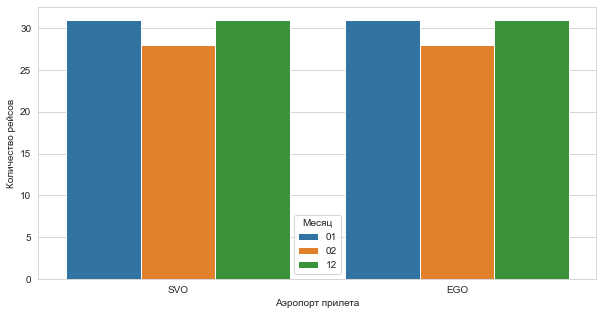

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'arrival_airport', hue = 'month', data = df)
plt.xlabel('Аэропорт прилета')
plt.ylabel('Количество рейсов')
plt.legend(title='Месяц')

### 1. Анализ рейсов в Москву

Прямое расстояние от Анапы до Москвы - 1207 км. 

In [38]:
df_dec_SVO = df[(df['month'] == '12') & (df['arrival_airport'] == 'SVO')] # Полеты в Москву за декабрь 
df_SVO = df[df['arrival_airport'] == 'SVO']

In [39]:
desc_fly(df_SVO)

Максимальная прибыль - 1595187.0 руб,
Средняя прибыль-1348507 руб,    
Минимальная прибыль-1070761.0 руб


#### 1.1 Анализ прибыльности рейсов в МОСКВУ за ДЕКАБРЬ

In [40]:
desc_fly(df_dec_SVO)

Максимальная прибыль - 1595187.0 руб,
Средняя прибыль-1355579 руб,    
Минимальная прибыль-1070761.0 руб


In [41]:
# Мини датасет для всех рейсов в Москву
d_M = df_SVO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().reset_index()
d_M.columns

Index(['day', 'full_of_seat', 'dow', 'profit'], dtype='object')

Text(72.0, 1250000, 'Невыгодные\n     рейсы')

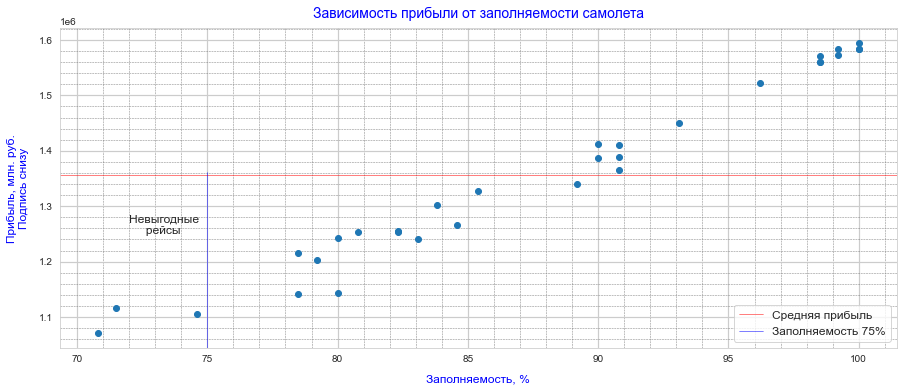

In [42]:

# Создаем полотно
plt.figure(figsize=(15, 20))

# Создаем несколько графиков на 1 полотне с помощью SUBPLOT. T- на конце!
# ПЕРВЫЙ ГРАФИК
plt.subplot(311) # РЯД - КОЛОНКА - ИНДЕКС
# Сам график
plt.scatter(df_dec_SVO['full_of_seat'], df_dec_SVO['profit'])
#sns.scatterplot(data=df_dec_SVO, x='full_of_seat', y='profit', hue='dow')
# Название осей
plt.xlabel('Заполняемость, %', fontsize=12, color='blue', labelpad=10)
plt.ylabel('Прибыль, млн. руб.\nПодпись снизу', fontsize=12, color='blue', labelpad=10)
# Название графика
plt.title('Зависимость прибыли от заполняемости самолета', fontsize=14, color='blue', pad=10)
# Параметры сетки
plt.grid(which='major', linewidth=1.2) # Главная 
plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
plt.minorticks_on() # Включить показ минорной сетки
# Добавление линии (горизонтальной) на график
plt.axhline(y=1355579, xmin=0, xmax=1, label='Средняя прибыль', linewidth=0.5, color='r')
plt.axvline(x=75., ymin=0, ymax=0.55, label='Заполняемость 75%', linewidth=0.5, color='b')
plt.legend(fontsize=12, frameon=True, loc='lower right')
plt.text(72., 1250000, 'Невыгодные\n     рейсы', fontsize=12)

# PLT.SCATTER

Именно в графике plt.scatter - работают нормально функции нарисовки линии и текста

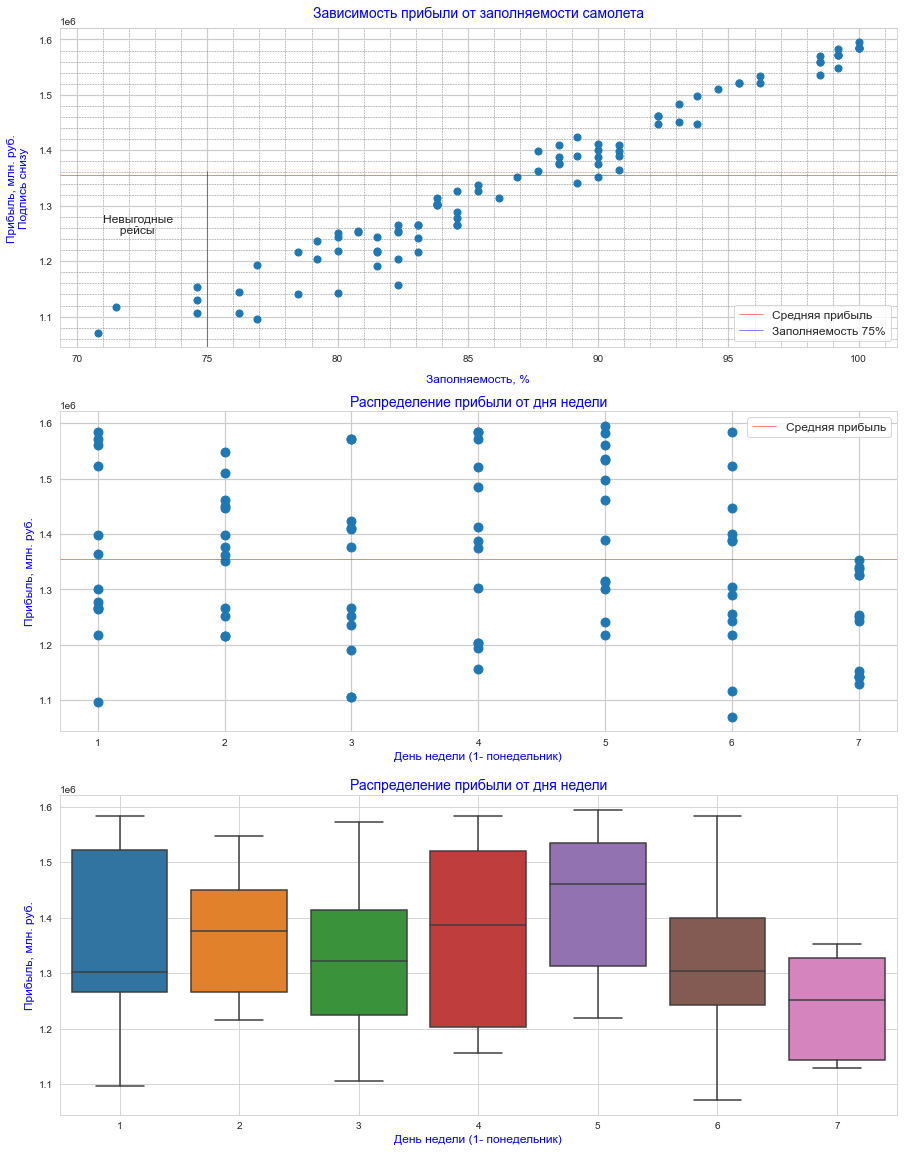

In [43]:
# Создаем полотно
plt.figure(figsize=(15, 20))

# Создаем несколько графиков на 1 полотне с помощью SUBPLOT. T- на конце!
# ПЕРВЫЙ ГРАФИК plt.scatter(x,y)
plt.subplot(311) # РЯД - КОЛОНКА - ИНДЕКС
# Сам график
plt.scatter(df_SVO['full_of_seat'], df_SVO['profit'], s=50)
# Название осей
plt.xlabel('Заполняемость, %', fontsize=12, color='blue', labelpad=10)
plt.ylabel('Прибыль, млн. руб.\nПодпись снизу', fontsize=12, color='blue', labelpad=10)
# Название графика
plt.title('Зависимость прибыли от заполняемости самолета', fontsize=14, color='blue', pad=10)
# Параметры сетки
plt.grid(which='major', linewidth=1.2) # Главная 
plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
plt.minorticks_on() # Включить показ минорной сетки
# Добавление линии (горизонтальной) на график
plt.axhline(y=1355579, xmin=0, xmax=1, label='Средняя прибыль', linewidth=0.5, color='r')
plt.axvline(x=75., ymin=0, ymax=0.55, label='Заполняемость 75%', linewidth=0.5, color='b')
plt.legend(fontsize=12, frameon=True, loc='lower right')

plt.text(71., 1250000, 'Невыгодные\n     рейсы', fontsize=12)

# ВТОРОЙ ГРАФИК plt.scatter(x,y)


plt.subplot(312) # РЯД - КОЛОНКА - ИНДЕКС
plt.scatter(df_SVO['dow'], df_SVO['profit'], s=80)
# Название осей
plt.xlabel('День недели (1- понедельник)', fontsize=12, color='blue')
plt.ylabel('Прибыль, млн. руб.', fontsize=12, color='blue')
# Название графика
plt.title('Распределение прибыли от дня недели', fontsize=14, color='blue',pad=5)
# Параметры сетки
plt.grid(which='major', linewidth=1.2) # Главная 
plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
#plt.minorticks_on() # Включить показ минорной сетки
plt.axhline(y=1355579, xmin=0, xmax=1, label='Средняя прибыль', linewidth=0.5, color='r')
plt.legend(fontsize=12, frameon=True, loc='upper right')


# ТРЕТИЙ ГРАФИК sns.boxplot(x='', y='', data=)
plt.subplot(313) # РЯД - КОЛОНКА - ИНДЕКС
sns.boxplot(x='dow', y='profit', data=d_M)
# Название осей
plt.xlabel('День недели (1- понедельник)', fontsize=12, color='blue')
plt.ylabel('Прибыль, млн. руб.', fontsize=12, color='blue')
# Название графика
plt.title('Распределение прибыли от дня недели', fontsize=14, color='blue' )
# Параметры сетки
plt.grid(True) # Главная 

# PLT.BAR и PLT.BARH

In [44]:
print(df_SVO['dow'].unique()) # Мы нашли уникальные элементы, но они не попорядку
print(np.sort(df_SVO['dow'].unique())) # отсортируем и с помощью np.sort (СПИСОК b)

[2 5 7 1 6 3 4]
[1 2 3 4 5 6 7]


In [45]:
df_SVO['dow'].value_counts() # Теперь подсчитываем уникальные элементы

7    13
6    13
5    13
4    13
2    13
1    13
3    12
Name: dow, dtype: int64

Но они идут не в том порядке. Нужно отсортировать по индексу

In [46]:
df_SVO['dow'].value_counts().sort_index()

1    13
2    13
3    12
4    13
5    13
6    13
7    13
Name: dow, dtype: int64

И создать список, которые будет соответсвовать размеру списка b, чтобы рисовалась столбчатая диаграмма.

In [47]:
a = []
for i in range(1, len(df_SVO['dow'].value_counts())+1):
    a.append(df_SVO['dow'].value_counts().sort_index()[i])

a

[13, 13, 12, 13, 13, 13, 13]

In [48]:
# Название подписей к столбцам
lab=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
# Цвет столбцов, можно через цикл задать цвет по условиям
colors = ['b', 'b', 'r', 'b', 'b', 'g', 'g']

NameError: name 'b' is not defined

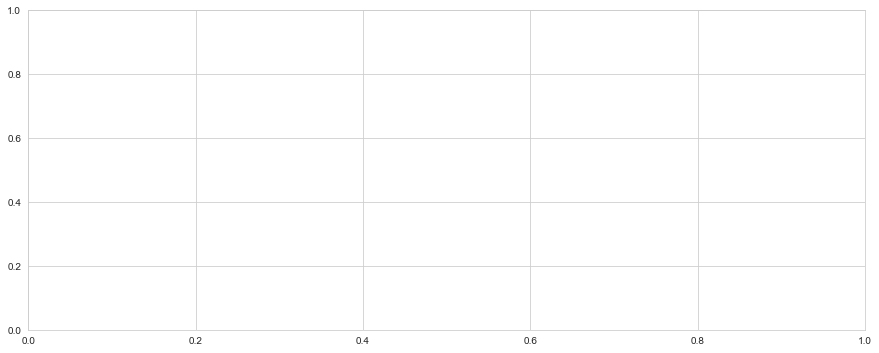

In [49]:
# Создаем полотно
plt.figure(figsize=(15, 20))

# Создаем несколько графиков на 1 полотне с помощью SUBPLOT. T- на конце!
# ПЕРВЫЙ ГРАФИК plt.scatter(x,y)
plt.subplot(311) # РЯД - КОЛОНКА - ИНДЕКС
# Сам график
plt.bar(b, a, width=0.5, tick_label=lab, color=colors)
# Название осей
plt.xlabel('День недели', fontsize=12, color='blue', labelpad=10)
plt.ylabel('Количество дней недели в 3х месяцах', fontsize=12, color='blue', labelpad=10)
# Название графика
plt.title('Сколько дней недели в 3х месяцах', fontsize=14, color='blue', pad=10)
# Параметры сетки
#plt.grid(which='major', linewidth=1.2) # Главная 
#plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
#plt.minorticks_on() # Включить показ минорной сетки
# Добавление линии (горизонтальной) на график
#plt.axhline(y=1355579, xmin=0, xmax=1, label='Средняя прибыль', linewidth=0.5, color='r')
#plt.axvline(x=75., ymin=0, ymax=0.55, label='Заполняемость 75%', linewidth=0.5, color='b')
#plt.legend(fontsize=12, frameon=True, loc='lower right')

#plt.text(71., 1250000, 'Невыгодные\n     рейсы', fontsize=12)


### Пример групповой диаграммы

Для этого нам нужно будет 2 датасета.
Суть диаграммы:

- Для каждого дня недели показать его максимальный и минимальный доходы.

In [50]:
day_max = df_SVO.groupby(['dow'])['profit'].max()
day_min = df_SVO.groupby(['dow'])['profit'].min()

In [51]:
# Первый список 
dmax=[]
for i in range(1, len(day_max)+1):
    dmax.append(day_max[i])
# Второй список
dmin=[]
for i in range(1, len(day_min)+1):
    dmin.append(day_min[i])
# Сами значения
b = np.sort(df_SVO['dow'].unique())

In [52]:
len(dmax)

7

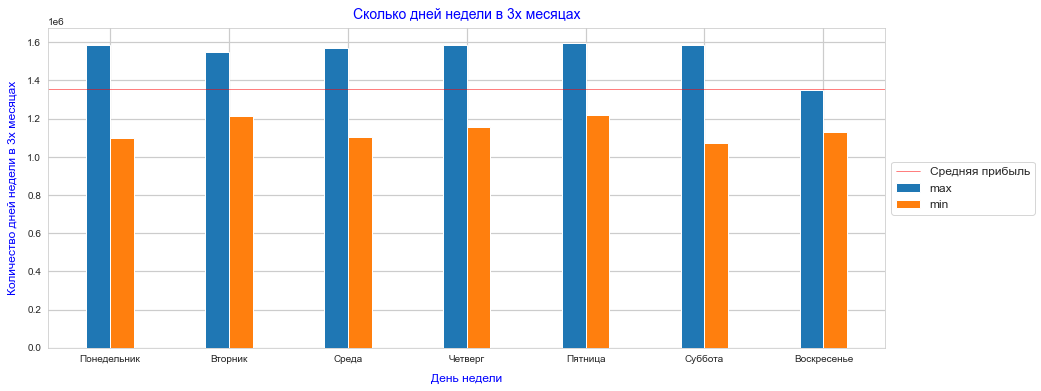

In [53]:
# Создаем полотно
plt.figure(figsize=(15, 20))

# Создаем несколько графиков на 1 полотне с помощью SUBPLOT. T- на конце!
# ПЕРВЫЙ ГРАФИК plt.scatter(x,y)
plt.subplot(311) # РЯД - КОЛОНКА - ИНДЕКС
# Сам график
plt.bar(b, dmax, width=-0.2, align='edge', label='max', tick_label=lab)
plt.bar(b, dmin, width=0.2,align='edge', label='min')
# Название осей
plt.xlabel('День недели', fontsize=12, color='blue', labelpad=10)
plt.ylabel('Количество дней недели в 3х месяцах', fontsize=12, color='blue', labelpad=10)
# Название графика
plt.title('Сколько дней недели в 3х месяцах', fontsize=14, color='blue', pad=10)
# Параметры сетки
plt.grid(which='major', linewidth=1.2) # Главная 
#plt.grid(which='minor', linestyle='--', color='gray', linewidth=0.5) # Вспомогательная
#plt.minorticks_on() # Включить показ минорной сетки
# Добавление линии (горизонтальной) на график
plt.axhline(y=1355579, xmin=0, xmax=1, label='Средняя прибыль', linewidth=0.5, color='r')
#plt.axvline(x=75., ymin=0, ymax=0.55, label='Заполняемость 75%', linewidth=0.5, color='b')
plt.legend(fontsize=12, frameon=True, bbox_to_anchor=(1, 0.6))

#plt.text(71., 1250000, 'Невыгодные\n     рейсы', fontsize=12)

Напишем простую программу, которая загружает картинку из интернета
по заданному URL и отображает ее с использованием библиотеки
Matplotlib:

In [54]:
from PIL import Image
import requests
from io import BytesIO

In [55]:
response = requests.get('https://w-dog.ru/wallpapers/9/5/330489125512351/dzhordzh-\
veltche-poberezhe-okean-porody-more-pejzazh-volny-shtorm-skaly-burya-temnyj-sinij-sumerki-nebo-vecher-temnoe-nebo.jpg')

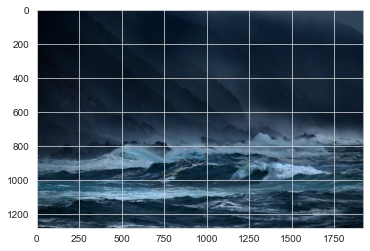

In [56]:
img = Image.open(BytesIO(response.content))
plt.imshow(img)

Text(0.5, 1.0, 'Profit per day of week')

<Figure size 1080x720 with 0 Axes>

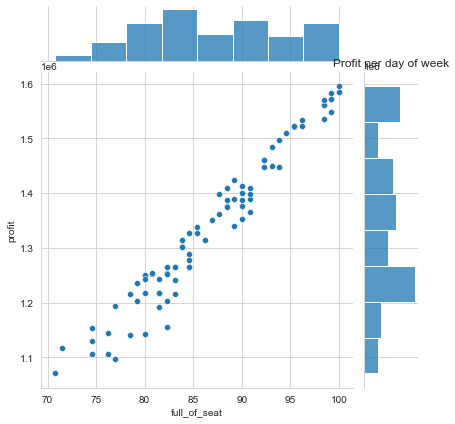

In [57]:
# jointplot - рисуется в сабплотах только сам собой.
plt.figure(figsize=(15, 10))
ris = sns.jointplot(x='full_of_seat', y='profit', data=d_M)
#plt.setp(ris.get_xticklabels())
plt.title('Profit per day of week')

In [58]:
d_M_12['profit'].idxmax() # Индекс максимального значения

NameError: name 'd_M_12' is not defined

In [59]:
d_M_12.at[5, 'full_of_seat'] # Достаем значение интересующего на столбца по индексу

NameError: name 'd_M_12' is not defined

Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

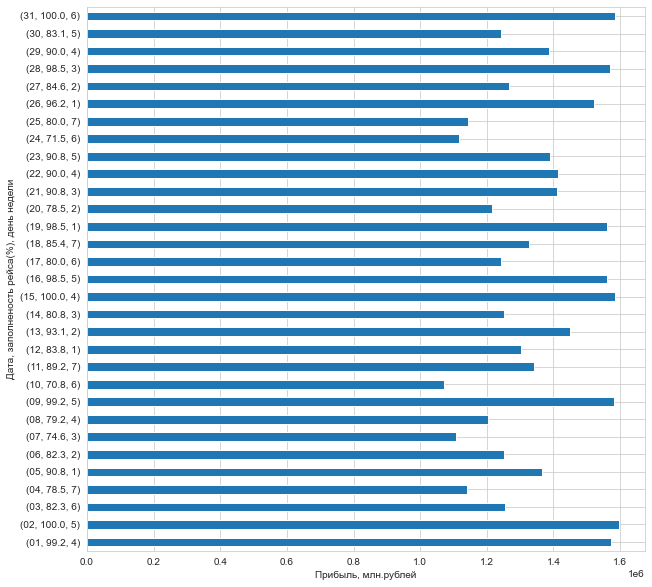

In [60]:
plt.figure(figsize=(10, 10))
df_dec_SVO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Какой-то явной зависимости прибыли от дня месяца в декабре не наблюдается.

Посмотрим зависимость распределения прибыли от заполнености самолета:

Text(0, 0.5, 'Заполненость рейса(%), день недели')

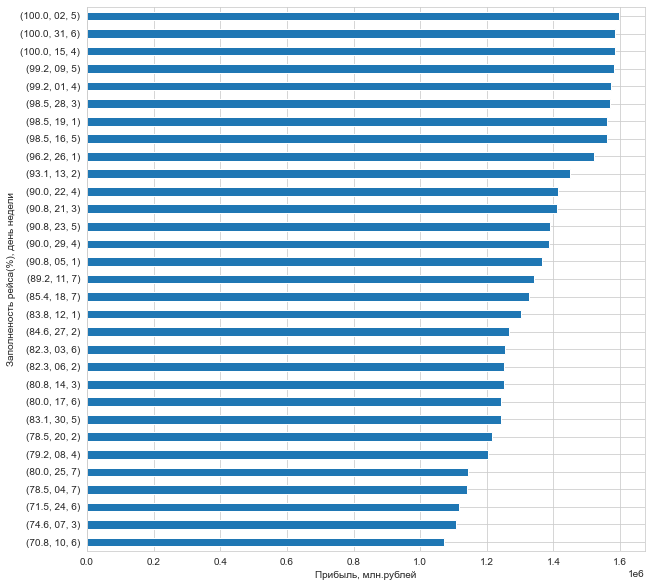

In [61]:
plt.figure(figsize=(10, 10))
d_M_12 = df_dec_SVO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

Теперь видно, что прибыль очень сильно зависит от заполнености самолета. Также, в декабре в Москву заполнен полностью самолет был только 3 раза. И судя по датам это начало месяца(02.12), середина (15.12) и конец месяца (31.12) (Ну здесь и праздник может играть роль). 

In [62]:
per_seat(df_dec_SVO)

Заполняемость самолета в рейсе, за месяц:
70+ - 19.35 %,
80+ - 32.26 %,    
90+ - 38.71 %,
100 - 9.68 %


Почти 1 неделю в декабре, самолет вылетает из Анапы в Москву с заполненостью менее 80 %.

Так как заполняемость главный фактор прибыльности, давайте посмотрим в какие дни недели чаще всего прибыль была меньше среднего значения. 

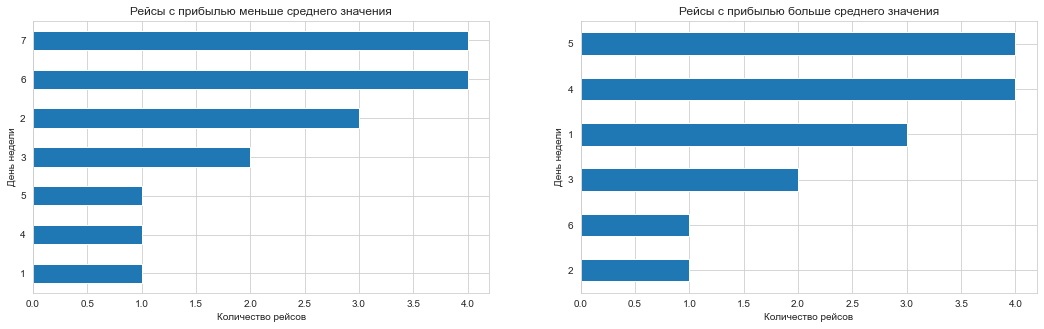

In [63]:
profit_on_day(df_dec_SVO)

Из графика следует, что в субботу, и воскресенье осуществлялись рейсы, у которых прибыль меньше средней по направлению за декабрь. Также и вторник с 3 рейсами. И наоборот в четверг, пятницу, и понедельник чаще вылетали рейсы с высокой прибыльностью.
Стоит обратить внимание на 1 субботу, где рейс был заполнен на 100% - это 31 декабря канун Нового года, и эта суббота - особенная. 

Вывод:
Зимой Анапа не представляет собой ценности как курорт, поэтому из Анапы люди в Москву, скорее всего, вылетают либо по работе либо на выходные в Москву. 

Если речь идет о работе, то наверное неудобно вылетать в выходные дни и снимать номер в Москве, чтобы дождаться рабочей недели. А с учетом того, что рейсы вылетают утром, удобнее летеь в понедельник. 

Прибыльные рейсы в четверг и пятницу, говорят о желании провести выходные в Москве и тут лучше лететь за день, чтобы не тратить половину субботы на прилет, размещение и т.д.

Рекомендации в декабре по направлению Анапа- Москва, сократить или отменить рейсы в Москву по выходным дням. 

#### 1.2 Анализ прибыльности рейсов в МОСКВУ за ЯНВАРЬ

In [64]:
df_jan_SVO = df[(df['month'] == '01') & (df['arrival_airport'] == 'SVO')] # Полеты в Москву за январь

In [65]:
desc_fly(df_jan_SVO)

Максимальная прибыль - 1584361.0 руб,
Средняя прибыль-1357619 руб,    
Минимальная прибыль-1096361.0 руб


Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

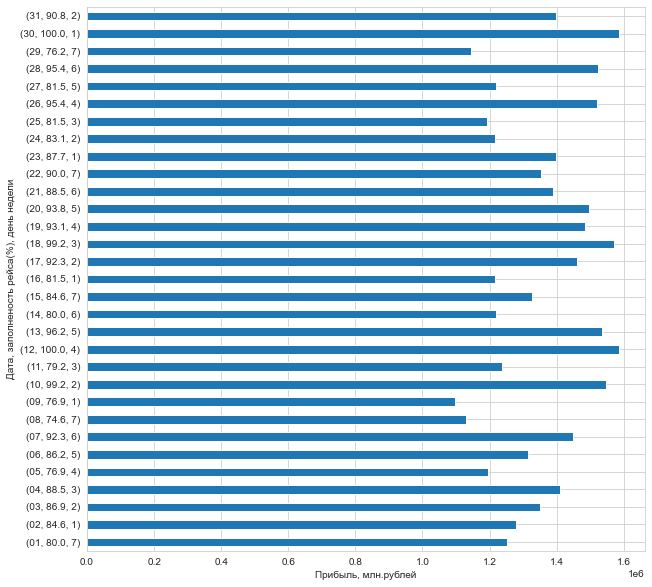

In [66]:
plt.figure(figsize=(10, 10))
df_jan_SVO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Нет ожидаемого спада перелтов в Новогодние праздники.

Посмотрим зависимость распределения прибыли от заполнености самолета:

Text(0, 0.5, 'Заполненость рейса(%), день недели')

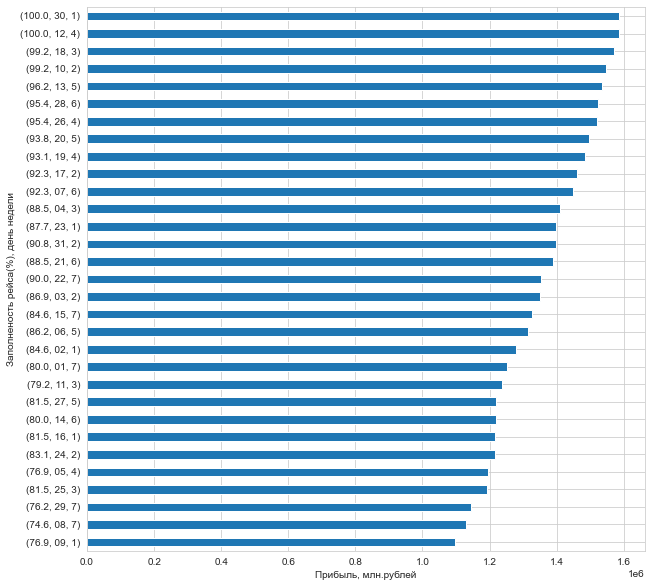

In [67]:
plt.figure(figsize=(10, 10))
df_jan_SVO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

Cудя по датам 100% заполняемость самолета имеется на конец месяца (30.01) и в середине месяца (12.01). Схожая ситуация с декабрем.

In [68]:
per_seat(df_jan_SVO)

Заполняемость самолета в рейсе, за месяц:
70+ - 16.13 %,
80+ - 41.94 %,    
90+ - 35.48 %,
100 - 6.45 %


В январе также как и вДекабре, примено 1 неделю в месяц самолеты летают с низкой загруженостью.

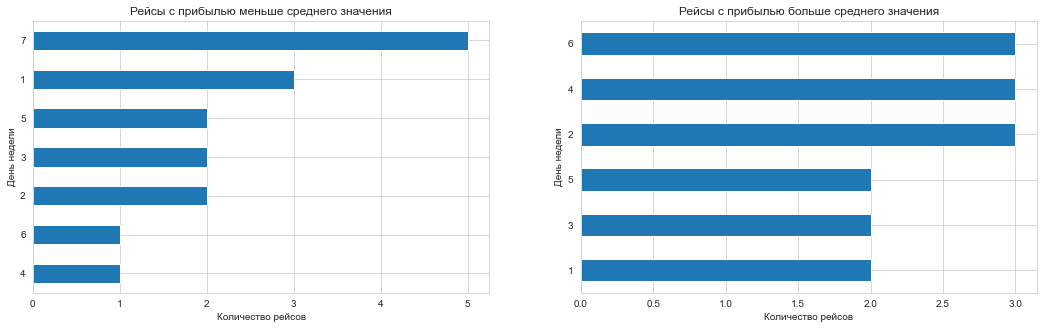

In [69]:
profit_on_day(df_jan_SVO)

Интересно. Воскресенье остается лидером среди дней, когда прибыль за рейс ниже среднего значения. Однако, можно предположить, что и суббота осталась бы на правом графике, если бы не суббота выпавшая на Рождество (07.01), рейс в этот день имел высокую загруженность, нехарактерную для субботы. 

Рекомендации в Январе по направлению Анапа- Москва, сократить или отменить рейсы в Москву по выходным дням. Но с учетом праздничных дней.

#### 1.3 Анализ прибыльности рейсов в МОСКВУ за ФЕВРАЛЬ

In [52]:
df_feb_SVO = df[(df['month'] == '02') & (df['arrival_airport'] == 'SVO')] # Полеты в Москву за февраль

In [53]:
desc_fly(df_feb_SVO)

Максимальная прибыль - 1572161.0 руб,
Средняя прибыль-1330588.0 руб,    
Минимальная прибыль-1106161.0 руб


Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

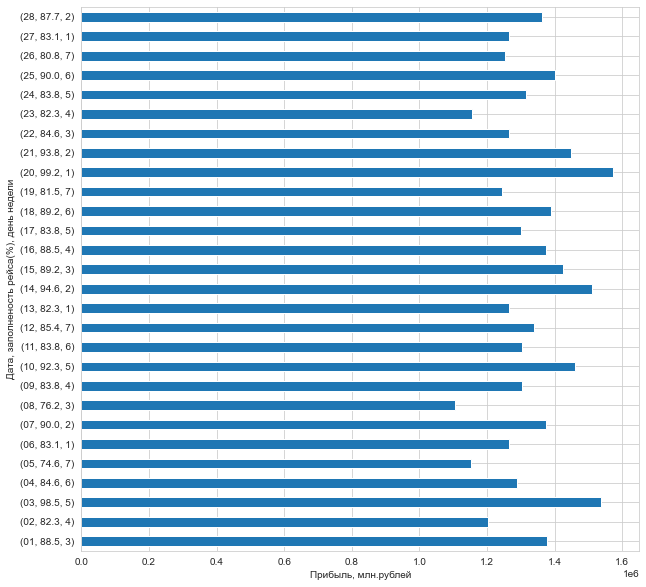

In [54]:
plt.figure(figsize=(10, 10))
df_feb_SVO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Text(0, 0.5, 'Заполненость рейса(%), день недели')

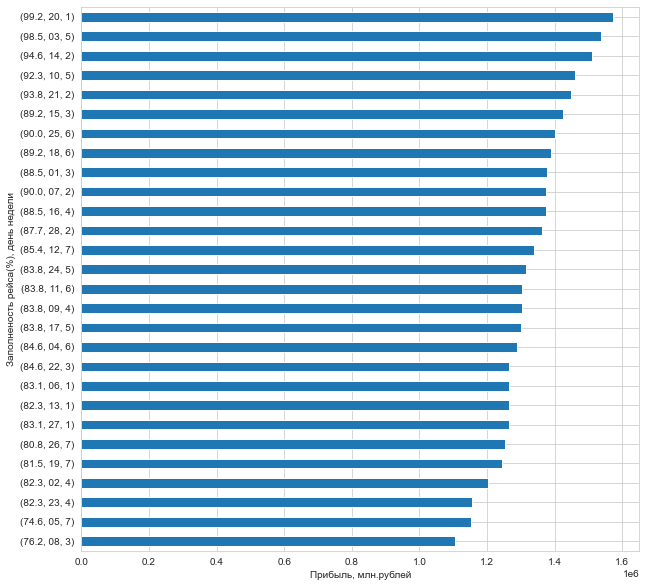

In [55]:
plt.figure(figsize=(10, 10))
df_feb_SVO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

In [56]:
per_seat(df_feb_SVO, feb=True)

Заполняемость самолета в рейсе, за месяц:
70+ - 7.14 %,
80+ - 67.86 %,    
90+ - 25.0 %,
100 - 0.0 %


В феврале вообще не было полностью заполненых рейсов. Большее количество самолетов улетали с заполненостью более 80 % но менее 90%. Интересно, что даже в День защитника Отечества, праздничный день, заполняемость рейса была одной из худших. Не все праздники положительно влияют на заполняемость рейса. 

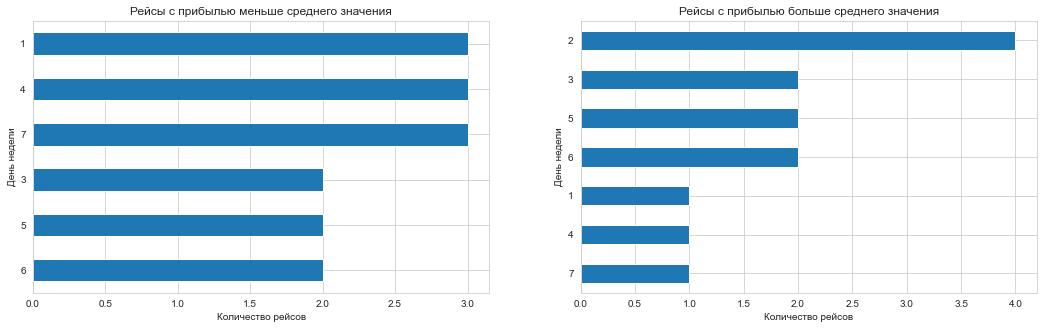

In [57]:
profit_on_day(df_feb_SVO)

Рекомендации в Феврале по направлению Анапа- Москва, сократить или отменить рейсы в Москву по воскресеньям.

### Анализ прибыльности по дням недели за весь зимний период для рейсов в Москву

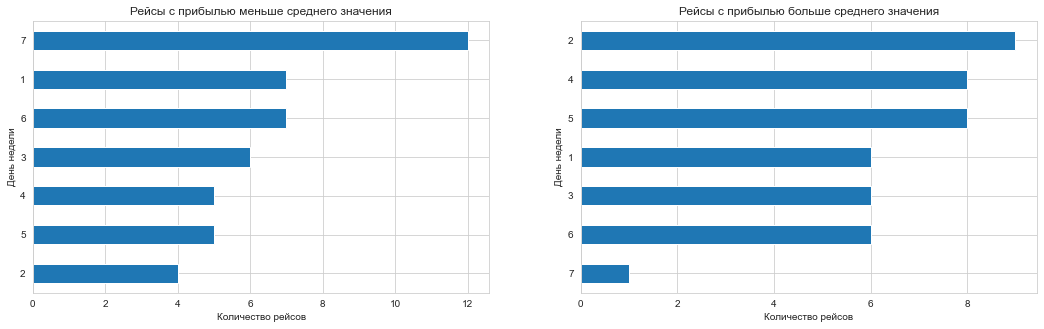

In [58]:
profit_on_day(df_SVO)

Общий вывод по направлению Анапа-Москва:
- Отменить рейсы по воскресеньям. 
- Сократить рейсы по субботам (Например полеты каждую 2 субботу).
- Сократить рейсы по понедельникам в Январе и Феврале. (Например полеты каждый 2 понедельник). Это может быть связано с тем, что в конце года всегда идут закрытия проектов, работ, отчетов и т.д. Поэтому рабочие командировки в Москву в начале недели в Декабре возрастают. В начале же года, возможно, такой потребности явной нет, поэтому, прибыль рейсов в понедельник сокращается. 
- Сократить рейсы по средам в Феврале (Например полеты каждую 2 среду)

### 2. Анализ рейсов в Белгород

Прямое расстояние от Анапы до Белгорода - 636 км

In [60]:
df_dec_EGO = df[(df['month'] == '12') & (df['arrival_airport'] == 'EGO')] # Полеты в Белгород за декабрь 
df_EGO = df[df['arrival_airport'] == 'EGO']

In [61]:
desc_fly(df_EGO)

Максимальная прибыль - 636922.0 руб,
Средняя прибыль-584019.0 руб,    
Минимальная прибыль-402622.0 руб


#### 2.1 Анализ прибыльности рейсов в БЕЛГОРОД за ДЕКАБРЬ

In [62]:
desc_fly(df_dec_EGO)

Максимальная прибыль - 636922.0 руб,
Средняя прибыль-587751.0 руб,    
Минимальная прибыль-503422.0 руб


Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

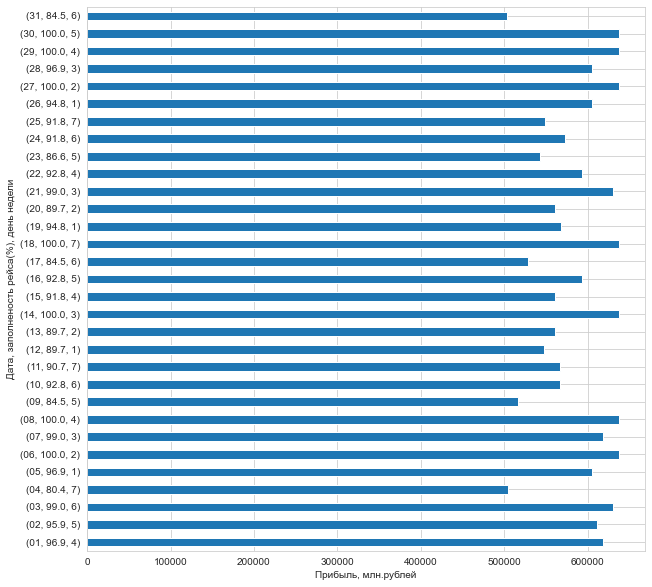

In [63]:
plt.figure(figsize=(10, 10))
df_dec_EGO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Text(0, 0.5, 'Заполненость рейса(%), день недели')

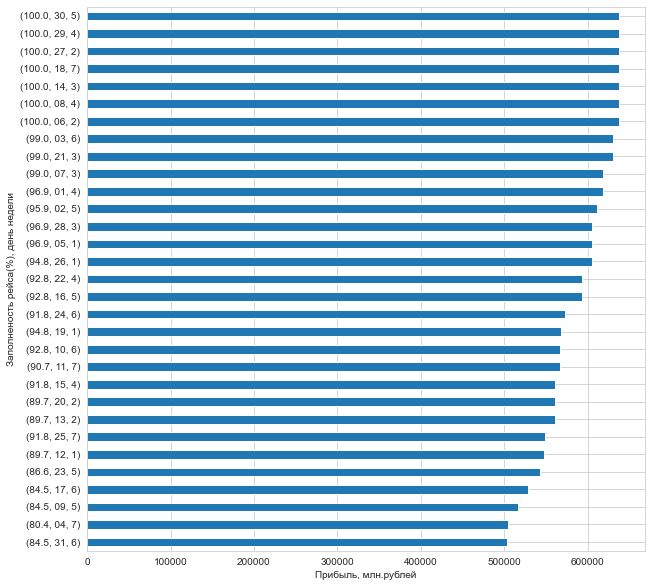

In [64]:
plt.figure(figsize=(10, 10))
df_dec_EGO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

В отличии от Москвы на Новый год (31.12) в Белгород полетело очень мало людей. Зато рейс 30.12 принес максимальную прибыль.
Стоит отметить, что 2 дня в начале месяца, 2 дня в середине месяца и 3 дня в конце месяца принесли максимальные доходы. Картина похожа на ту, что была с полетами в Москву

In [65]:
per_seat(df_dec_EGO)

Заполняемость самолета в рейсе, за месяц:
70+ - 0.0 %,
80+ - 25.81 %,    
90+ - 51.61 %,
100 - 22.58 %


Отлично! 7 дней, в общем, самолет летал заполненый на 100%, а заполненности менее 80% вообще не было. 

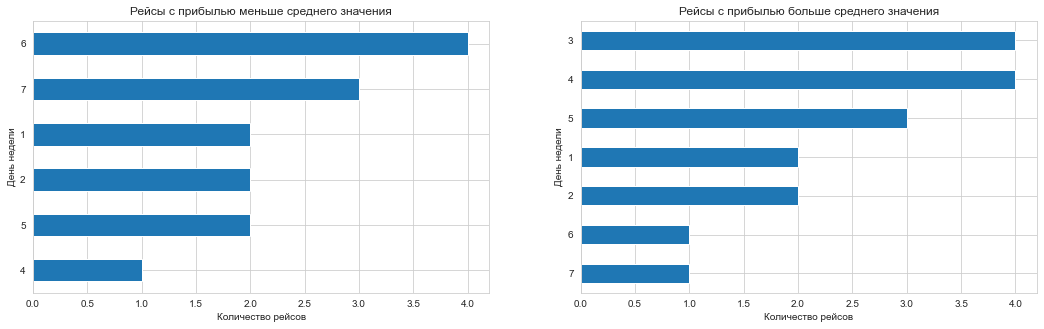

In [66]:
profit_on_day(df_dec_EGO)

Ситуаця похожа. Рейсы в субботу и воскресенье приносят прибыль меньше среднего. А вот сорваться в Белгород в середине недели любят многие жители Анапы. Понедельник 50х50, возможно стоит сократить рейсы по понедельникам.

#### 2.2 Анализ прибыльности рейсов в БЕЛГОРОД за ЯНВАРЬ

In [67]:
df_jan_EGO = df[(df['month'] == '01') & (df['arrival_airport'] == 'EGO')] # Полеты в Белгород за январь 

In [68]:
desc_fly(df_jan_EGO)

Максимальная прибыль - 636922.0 руб,
Средняя прибыль-583464.0 руб,    
Минимальная прибыль-402622.0 руб


Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

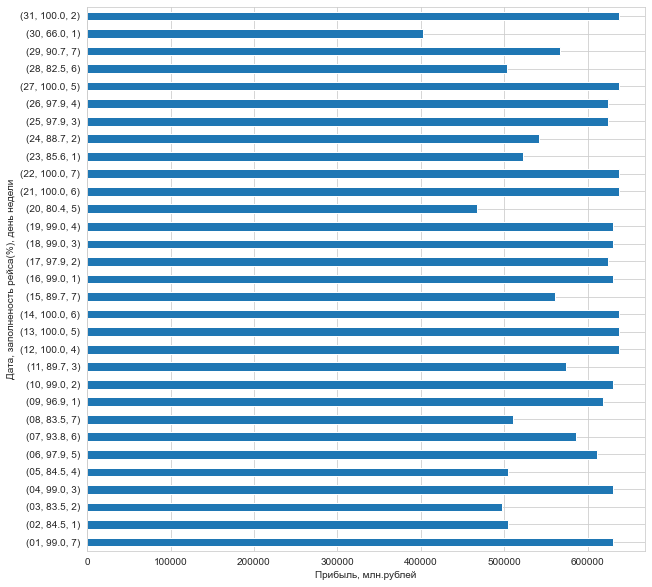

In [69]:
plt.figure(figsize=(10, 10))
df_jan_EGO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Text(0, 0.5, 'Заполненость рейса(%), день недели')

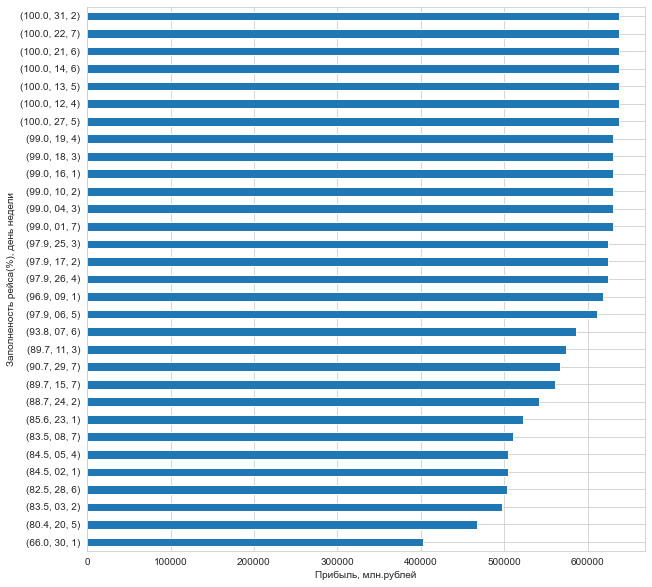

In [70]:
plt.figure(figsize=(10, 10))
df_jan_EGO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

Хорошая прибыль в январе получена от рейсов в конце месяца, и немного в середине месяца. Однако, 30.01 (понедельник) загруженность самолета была 66%, что является на данный момент минимальной загруженностью в наборе данных.

In [71]:
per_seat(df_jan_EGO)

Заполняемость самолета в рейсе, за месяц:
70+ - 0.0 %,
80+ - 32.26 %,    
90+ - 41.94 %,
100 - 22.58 %


Аналогично декабрю, 7 дней, в общем, самолет летал заполненый на 100%. В январе был самый малозагруженный рейс.

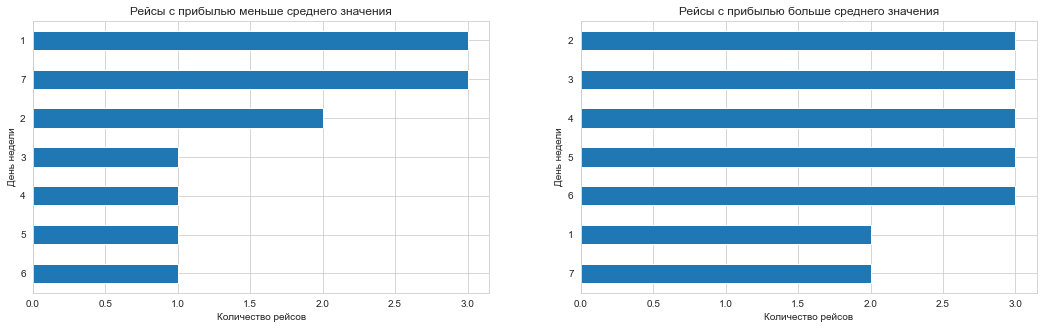

In [72]:
profit_on_day(df_jan_EGO)

Рукомендуется сократить рейсы в январе из Анапы в Белгород вылетающие по воскресеньям и понедельникам.

#### 2.3 Анализ прибыльности рейсов в БЕЛГОРОД за ФЕВРАЛЬ

In [73]:
df_feb_EGO = df[(df['month'] == '02') & (df['arrival_airport'] == 'EGO')] # Полеты в Белгород за февраль

In [74]:
desc_fly(df_feb_EGO)

Максимальная прибыль - 636922.0 руб,
Средняя прибыль-580501.0 руб,    
Минимальная прибыль-402622.0 руб


Text(0, 0.5, 'Дата, заполненость рейса(%), день недели')

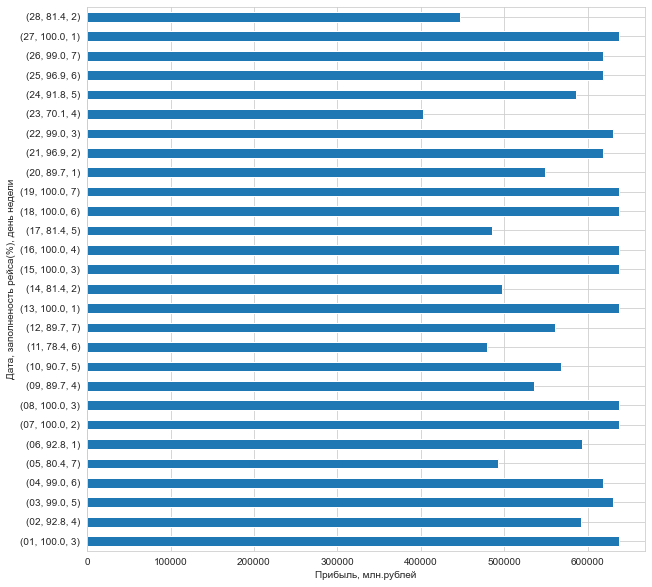

In [75]:
plt.figure(figsize=(10, 10))
df_feb_EGO.groupby(['day', 'full_of_seat', 'dow'])['profit'].max().plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Дата, заполненость рейса(%), день недели')

Text(0, 0.5, 'Заполненость рейса(%), день недели')

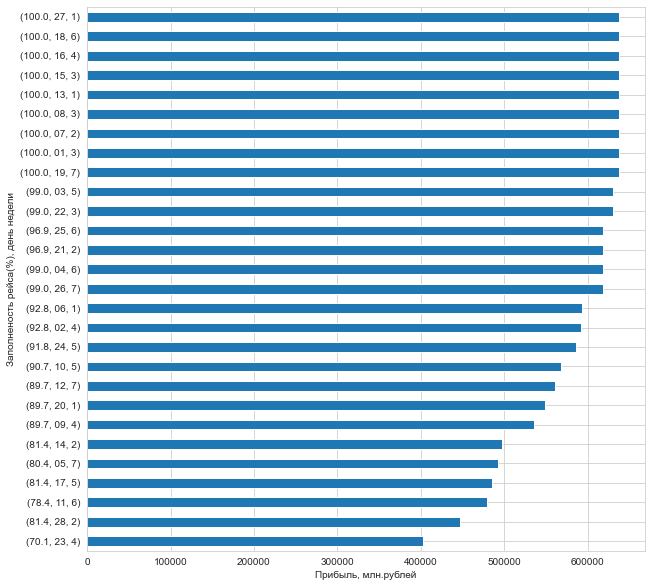

In [76]:
plt.figure(figsize=(10, 10))
df_feb_EGO.groupby(['full_of_seat', 'day', 'dow'])['profit'].max().sort_values(ascending=True).plot(kind='barh');
plt.xlabel('Прибыль, млн.рублей')
plt.ylabel('Заполненость рейса(%), день недели')

In [77]:
per_seat(df_jan_EGO, feb=True)

Заполняемость самолета в рейсе, за месяц:
70+ - 0.0 %,
80+ - 35.71 %,    
90+ - 46.43 %,
100 - 25.0 %


Рекорд датасета, 9 из 28 дней самолеты из Анапы в Белгород летали с полной загрузкой. а в праздник 23.02 наблюдается минимальная прибыль от рейса. 

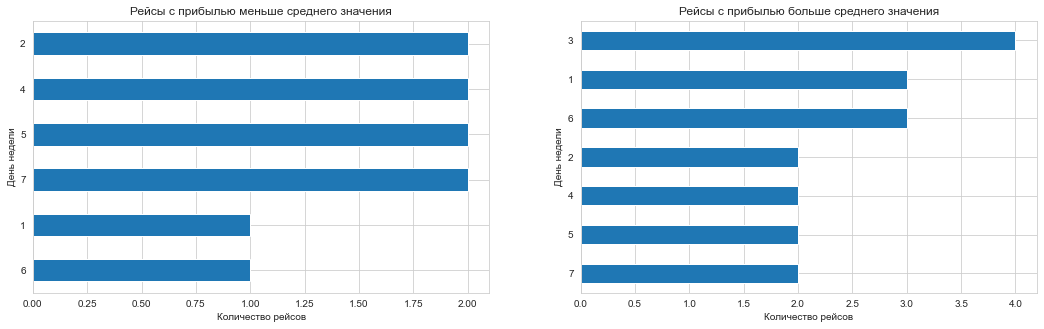

In [78]:
profit_on_day(df_feb_EGO)

Из графиков видно, что количество рейсов с меньшей прибыльностью  одинаково с более прибыльными рейсами. Следовательно можно рекомендовать отменить рейсы по воскресеньям и сократить рейсы по вторникам и четвергам. 

### Анализ прибыльности по дням недели за весь зимний период для рейсов в Белгород

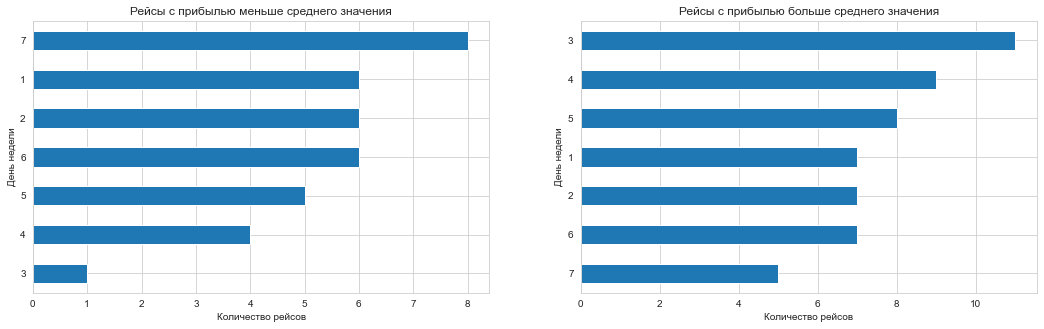

In [79]:
profit_on_day(df_EGO)

Общий вывод по направлению Анапа-Белгород:
- Отменить рейсы по воскресеньям. 
- Сократить рейсы по понедельникам в Январе и Феврале. (Например полеты каждый 2 понедельник). 
- Сократить рейсы по вторникам и четвергам в Феврале. 
- Для февраля можно рекомендовать летать в Белгород еженедельно по Средам и Субботам и каждый 2-й Понедельник. 